In [1]:
#Importing relevant libraries
from pdfminer.high_level import extract_text
import PyPDF2
from PyPDF2 import PdfReader
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import download
from gensim import corpora, models
from gensim.models import CoherenceModel
import os
import statistics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
import matplotlib.pyplot
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tensorflow as tf
import os
import pdfplumber
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from gensim.corpora import Dictionary
from gensim.models import HdpModel



# Download other resources
download('stopwords')
download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cdlacey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cdlacey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#Initial stats - file count

def count_files_in_folder(folder_path):
    # Initialize a counter for files
    file_count = 0

    # Walk through the directory and count files
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample_385'
total_files = count_files_in_folder(folder_path)
print("Total files in datasource: ", total_files)

Total files in datasource:  385


In [3]:
#Initial stats - page count

def count_pages_and_stats(folder_path):
    total_pages = 0
    page_counts = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                pdf_reader = PdfReader(file)
                num_pages = len(pdf_reader.pages)
                total_pages += num_pages
                page_counts.append(num_pages)

    mean_page_count = statistics.mean(page_counts)
    median_page_count = statistics.median(page_counts)

    return total_pages, mean_page_count, median_page_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample_385'
total_pages, mean_page_count, median_page_count = count_pages_and_stats(folder_path)

print("Total pages in all PDF files:", total_pages)
print("Mean page count per file:", mean_page_count)
print("Median page count per file:", median_page_count)

Total pages in all PDF files: 30365
Mean page count per file: 79.07552083333333
Median page count per file: 80.0


In [4]:
# Function for preprocessing text
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    french_stopwords = set(stopwords.words('french'))
    stop_words.update(french_stopwords)
    tokens = [token for token in tokens if token not in stop_words]
    # Remove numbers, symbols, and certain words
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    # Remove specific words or letters which are not useful
    additional_stopwords = {
        'mr.', 'mr', 'mrs.', 'ms.', 'speaker', 'bill', 'debate', 'hon', 'cpc', 'lib', 'bq', 'canadian', 
        'act', 'amend', 'amendment', 'canada', 'house', 'public', 'honour', 'minister', 'ministry', 'govern', 
        'member', 'program', 'primeminister', 'would', 'people', 'chair', 'committe', 'liber', 'polici', 'parliamentari', 
        'ndp', 'government', 'conserv', 'parties', 'partisan', 's', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'am', 'pm','year','time','motion','go', 'canadians', 
        'also', 'members', 'madam', 'committee', 'prime', 'senate', 'senator', 'hous',
        'one', 'govern', 'liberal', 'conservative', 'liberals', 'conservatives', 'speech', 'parliamentarian',
        'secretariat', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', '000', '1', '3', '5', '11', 
        '15', '22', '25', '2007', '2008', '2009', '2010', '2011',
        '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '‚Äô',
        '‚Äú', '‚Äù', "’",'...................',' ................................................',
        '........',"'s"}
    tokens = [token for token in tokens if token not in additional_stopwords]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# Directory path containing PDF files
pdf_directory = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample_385'

# List all PDF files in the directory
pdf_files = [os.path.join(pdf_directory, file) for file in os.listdir(pdf_directory) if file.endswith('.pdf')]

texts = []

# Loop through each PDF file and extract text
for pdf_file in pdf_files:
    with pdfplumber.open(pdf_file) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text()
        texts.append(text)

# Preprocess text
preprocessed_texts = [preprocess_text(text) for text in texts]

# Create a dictionary from the preprocessed text
dictionary = Dictionary(preprocessed_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]


In [5]:
#spliting data for cross validation
from sklearn.model_selection import train_test_split

train_corpus, test_corpus = train_test_split(corpus, test_size=0.2, random_state=42)

In [6]:
# Train the HDP model
hdp_model = HdpModel(train_corpus, id2word=dictionary)

In [7]:
#First evaluation of HDP model and number of topics identified per document)
rows = []

# Iterate through each document in the corpus
for i, doc in enumerate(corpus):
    doc_topics = hdp_model[doc]
    # Extract topic numbers and their probabilities
    topic_numbers = [topic[0] for topic in doc_topics]
    topic_probs = [topic[1] for topic in doc_topics]
    # Append the document's topics to the rows list
    rows.append([i, topic_numbers, topic_probs])

# Create a DataFrame from the list of rows
doc_topics_df = pd.DataFrame(rows, columns=['Document_Index', 'Topic_Numbers', 'Topic_Probabilities'])

# Display the DataFrame
doc_topics_df.head(10)

,Document_Index,Topic_Numbers,Topic_Probabilities
0,0,"[0, 1, 4, 5, 6, 7, 8, 11, 12, 15, 28, 32, 36, ...","[0.06649491764240421, 0.03081360027442871, 0.0..."
1,1,"[3, 20]","[0.4974659350616244, 0.5024498761115945]"
2,2,[1],[0.9999560486259604]
3,3,"[0, 1, 2, 4, 7]","[0.14973707593481264, 0.013983550230610212, 0...."
4,4,[2],[0.9999350786776484]
5,5,"[0, 1, 2, 4, 7, 9]","[0.2743400319172938, 0.08312557843338962, 0.12..."
6,6,[5],[0.9999246775912001]
7,7,[6],[0.9998325712499864]
8,8,"[0, 2, 31]","[0.27461191176778205, 0.05069966987415576, 0.6..."
9,9,"[3, 4, 16, 18, 22]","[0.6165115895062581, 0.03391863430410685, 0.04..."


In [8]:
# To find an approximate number of total topics identified within the HDP model, I found it easiest to train an
#LDA model on the HDP model. 
# Here we'll train an LDA model using the HDP model as a training mechanism
lda_model_t = hdp_model.suggested_lda_model()

# Get the topic distributions for each document
doc_topics = [lda_model_t.get_document_topics(doc) for doc in corpus]

# Count the number of unique topics
unique_topics = set()
for doc_topics in doc_topics:
    unique_topics.update([topic[0] for topic in doc_topics])

num_topics_identified = len(unique_topics)
print(f"Number of topics identified by HDP model: {num_topics_identified}")


Number of topics identified by HDP model: 39


In [9]:
#From the Literature Review, the ideal topics for LDA was found to be 7. 
from gensim.models import LdaModel

# Train the LDA model
lda_model = LdaModel(train_corpus, id2word=dictionary, num_topics=7, update_every=1, chunksize=10, passes=10)

In [10]:
#Evaluating LDA topic coherance values. 
from gensim.models import CoherenceModel

# Calculate coherence values for each topic
coherence_values = {}
for topic_num in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_num)
    topic_words = [term for term, _ in topic_terms]
    coherence_model = CoherenceModel(topics=[topic_words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.37832248266096113
1	0.8274994868811916
2	0.43092406930711097
3	0.8274994868811916
4	0.3465939617099905
5	0.8274994868811916
6	0.8274994868811916


In [11]:
# Finding the overall LDA model coherance value
topics = lda_model.show_topics(num_topics=-1, formatted=False)

# Calculate coherence values for each topic
coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print("Coherence Score for LDA model:", coherence_lda)

Coherence Score for LDA model: 0.7010199998587691


In [12]:
#Evaluating HDP topic coherance values, which were found to have a range below as well as above the LDA model
from gensim.models import CoherenceModel

hdp_topics = hdp_model.show_topics(num_topics=35, formatted=False)  # Get the top topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.3215889966810802
1	0.30904021545285104
2	0.3325399111275753
3	0.27681660511759437
4	0.3337010956216032
5	0.304702540268822
6	0.3200943170739304
7	0.3552289210145933
8	0.34036992626527157
9	0.3203435698656071
10	0.3214158673666039
11	0.31315341709965716
12	0.37742433969630745
13	0.3291918299271586
14	0.3019415513798386
15	0.3240623182246259
16	0.280752450556519
17	0.29416702808145156
18	0.2937178850274641
19	0.24887322217388688
20	0.3609061455216568
21	0.27910222730151524
22	0.28118665434982293
23	0.29476552416257695
24	0.3640585915053309
25	0.2231202347886288
26	0.30104352163190223
27	0.30140141543268795
28	0.3128934224036134
29	0.34451057136871316
30	0.3928035975441194
31	0.3445598517931259
32	0.3785026495794269
33	0.33229397026676777
34	0.22703961124927313


In [13]:
# Finding the overall coherhance value for HDP model
hdp_topics = hdp_model.show_topics(num_topics=35, formatted=False)  # Get the top topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Compute the average coherence value
avg_coherence_value = sum(coherence_values.values()) / len(coherence_values)

print("Overall Coherence Value for HDP model:", avg_coherence_value)

Overall Coherence Value for HDP model: 0.31535182848347443


In [14]:
#Generate df with dominant topics, the topic contribution and topic keywords for LDA model
import pandas as pd

def format_topics(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df


df_topic_keywords = format_topics(ldamodel=lda_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,0,0.5413,"commonsdeb, english, translat, order, work, na...","[common, debat, volum, number, session, parlia..."
1,0,0.5456,"commonsdeb, english, translat, order, work, na...","[common, debat, volum, number, session, parlia..."
2,2,0.5695,"need, work, want, support, make, like, get, kn...","[common, debat, volum, number, session, parlia..."
3,2,0.9987,"need, work, want, support, make, like, get, kn...","[parliament, session, common, debat, offici, r..."
4,0,0.6691,"commonsdeb, english, translat, order, work, na...","[common, debat, volum, number, session, parlia..."
5,2,0.9824,"need, work, want, support, make, like, get, kn...","[parliament, session, common, debat, offici, r..."
6,0,0.6697,"commonsdeb, english, translat, order, work, na...","[common, debat, volum, number, session, parlia..."
7,0,0.5948,"commonsdeb, english, translat, order, work, na...","[common, debat, volum, number, session, parlia..."
8,0,0.5394,"commonsdeb, english, translat, order, work, na...","[common, debat, volum, number, session, parlia..."
9,0,0.5310,"commonsdeb, english, translat, order, work, na...","[common, debat, volum, number, session, parlia..."


In [15]:
#Generate df of represtative text for dominant topics for LDA model
import pandas as pd

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format DF
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]


topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9774,"commonsdeb, english, translat, order, work, nation, new, countri, like, howev","[common, debat, volum, number, session, parliament, offici, report, hansard, wednesday, march, h..."
1,2,1.0000,"need, work, want, support, make, like, get, know, common, question","[parliament, session, common, debat, offici, report, hansard, volum, thursday, septemb, honour, ..."
2,4,0.4743,"ontario, qubec, britishcolumbia, tom, theminist, deanallison, davidsweet, leonbenoit, chriswarke...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, decemb, hon..."


In [16]:
#Generate df with dominant topics, the topic contribution and topic keywords for HDP model
import pandas as pd

def topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, topics in enumerate(ldamodel[corpus]):
        # Sort topics by contribution
        topics = sorted(topics, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(topics):
            if j == 0:  # Dominant topic
                topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(topic_num)])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df

df_topic_keywords = topics_sentences(ldamodel=hdp_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,7,0.2306,"work, need, want, right, make, care, support, like, countri, know, mani, say, get, common, impor...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, januari, ho..."
1,20,0.5024,"industri, quebec, aerospac, contract, ontario, want, work, commonsdeb, support, compani, bloc, e...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
2,1,1.0000,"work, order, right, want, support, need, like, make, question, commonsdeb, english, nation, know...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, june, honou..."
3,7,0.5122,"work, need, want, right, make, care, support, like, countri, know, mani, say, get, common, impor...","[parliament, session, common, debat, offici, report, hansard, volum, friday, june, honour, antho..."
4,2,0.9999,"work, need, want, support, tax, make, like, countri, know, say, get, question, right, health, us...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, may, hono..."
5,7,0.3867,"work, need, want, right, make, care, support, like, countri, know, mani, say, get, common, impor...","[parliament, session, common, debat, offici, report, hansard, volum, tuesday, march, honour, ant..."
6,5,0.9999,"work, commonsdeb, countri, english, support, make, need, like, translat, import, want, order, ne...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, april, hon..."
7,6,0.9998,"work, order, right, make, need, support, want, import, like, know, commun, commonsdeb, english, ...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, april, hon..."
8,31,0.6695,"gun, firearm, registri, quebec, polic, crime, regist, develop, use, econom, want, commonsdeb, su...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, april, hon..."
9,3,0.6165,"work, ontario, support, need, nation, english, want, countri, translat, make, commonsdeb, qubec,...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."


In [17]:
#Generate df of represtative text for dominant topics for HDP model
import pandas as pd

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,1.0000,"work, need, support, make, like, want, know, order, right, commun, question, import, countri, ge...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, april, hon..."
1,1,1.0000,"work, order, right, want, support, need, like, make, question, commonsdeb, english, nation, know...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, june, honou..."
2,2,0.9999,"work, need, want, support, tax, make, like, countri, know, say, get, question, right, health, us...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, may, hono..."
3,3,0.9999,"work, ontario, support, need, nation, english, want, countri, translat, make, commonsdeb, qubec,...","[common, debat, volum, number, session, parliament, offici, report, hansard, wednesday, may, hon..."
4,4,1.0000,"right, work, support, want, need, like, import, make, question, countri, english, order, commun,...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, june, honou..."
5,5,0.9999,"work, commonsdeb, countri, english, support, make, need, like, translat, import, want, order, ne...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, april, hon..."
6,6,1.0000,"work, order, right, make, need, support, want, import, like, know, commun, commonsdeb, english, ...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."
7,7,1.0000,"work, need, want, right, make, care, support, like, countri, know, mani, say, get, common, impor...","[parliament, session, common, debat, offici, report, hansard, volum, thursday, novemb, honour, a..."
8,8,1.0000,"work, right, question, want, need, make, like, import, know, commonsdeb, countri, quebec, suppor...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, june, hono..."
9,9,0.9999,"need, work, support, make, right, countri, want, like, tax, know, mani, commonsdeb, new, english...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, januari, h..."


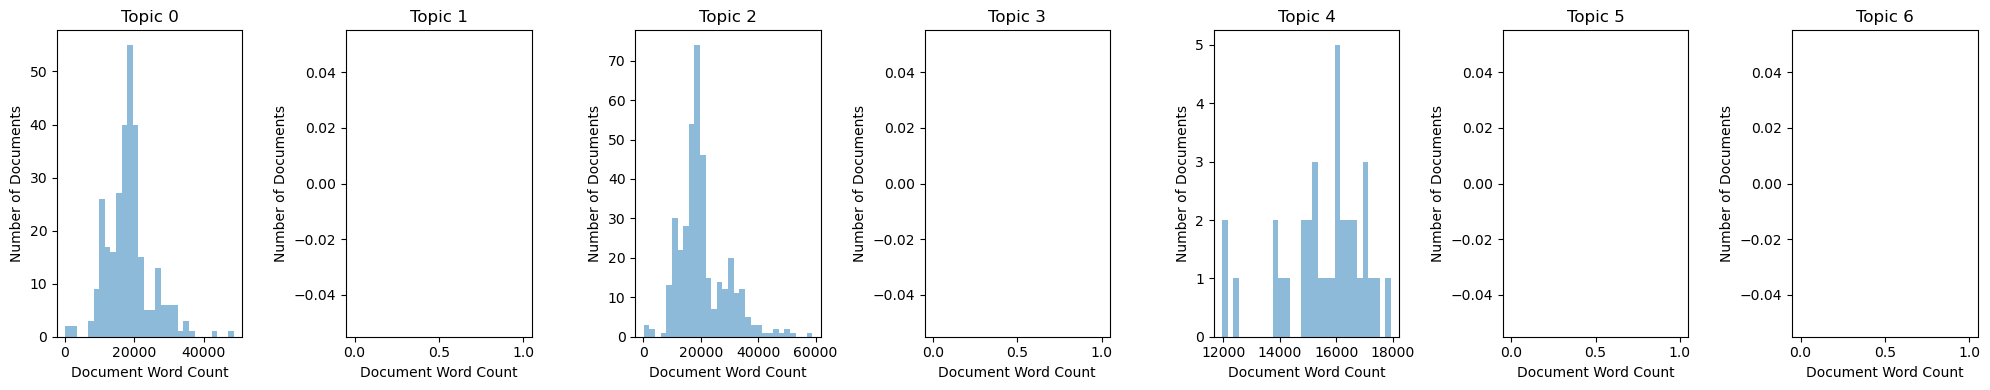

In [18]:
#Ploting document word count against nubmer of documents for LDA model
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 4))

for i in range(7):
    word_counts = []

    
    for doc in corpus:
        # Get the topic distribution for the document
        doc_topics = lda_model.get_document_topics(doc)

        # Check if the current topic is the dominant topic for the document
        for topic, prob in doc_topics:
            if topic == i:
                # Calculate the word count of the document and add it to the list
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    axes[i].hist(word_counts, bins=30, alpha=0.5)
    axes[i].set_title(f'Topic {i}')
    axes[i].set_xlabel('Document Word Count')
    axes[i].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

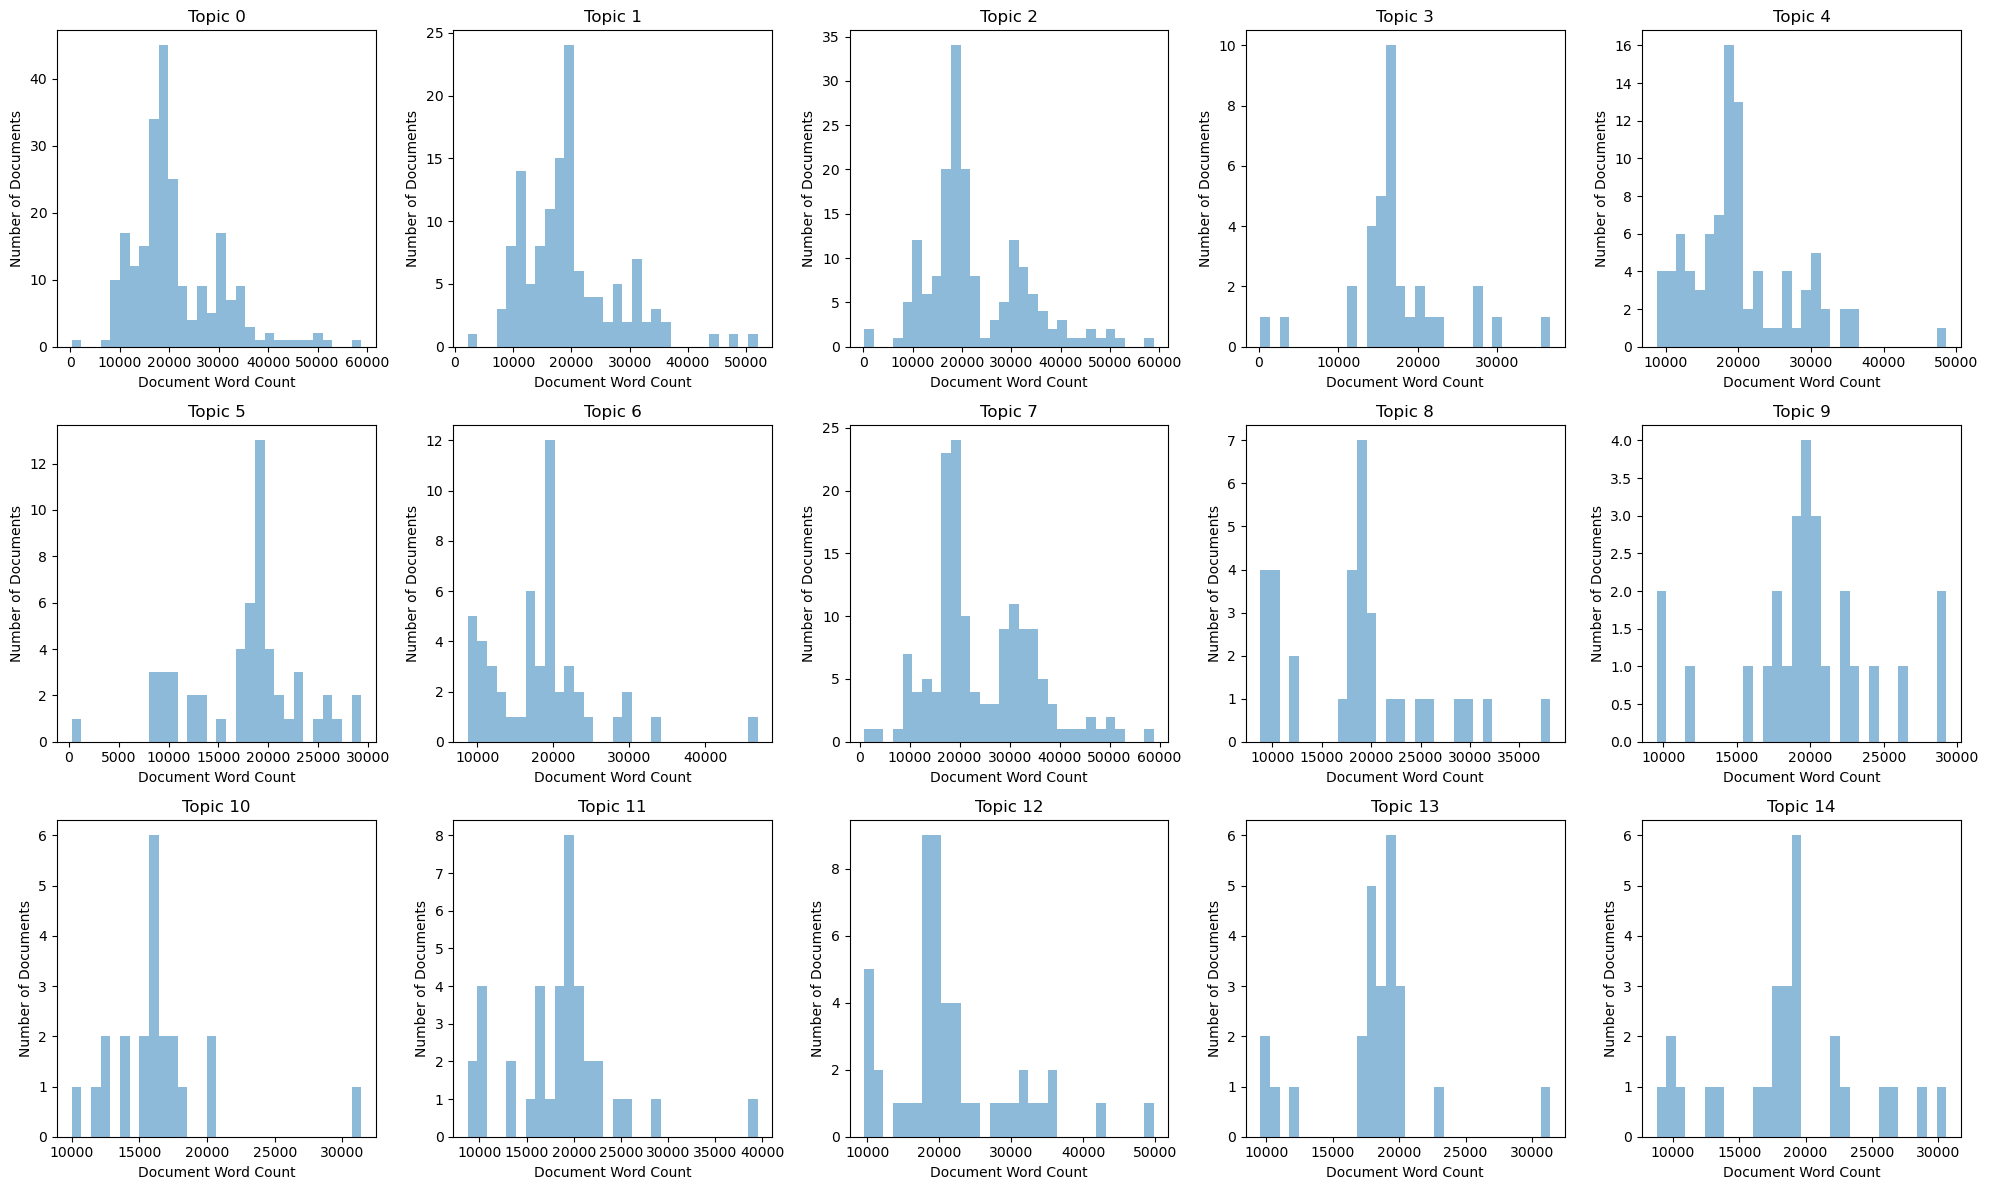

In [19]:
#Ploting document word count against nubmer of documents for HDP model
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))


for i in range(15):
    word_counts = []

    for doc in corpus:
        doc_topics = hdp_model[doc]

        for topic, prob in doc_topics:
            if topic == i:
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    # Determine the position of the subplot in the grid
    row_index = i // 5
    col_index = i % 5

    axes[row_index, col_index].hist(word_counts, bins=30, alpha=0.5)
    axes[row_index, col_index].set_title(f'Topic {i}')
    axes[row_index, col_index].set_xlabel('Document Word Count')
    axes[row_index, col_index].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

In [20]:
#Exploring the relevant terms for each topic of the LDA Model
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)

# Convert complex numbers to real numbers in topic coordinates
vis.topic_coordinates['x'] = vis.topic_coordinates['x'].apply(lambda x: x.real)
vis.topic_coordinates['y'] = vis.topic_coordinates['y'].apply(lambda y: y.real)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.420740 -0.012822       1        1  55.826676
0     -0.384675  0.002474       2        1  41.685911
4      0.134363  0.184998       3        1   2.484134
1      0.167763 -0.043663       4        1   0.000820
3      0.167763 -0.043663       5        1   0.000820
5      0.167763 -0.043663       6        1   0.000820
6      0.167763 -0.043663       7        1   0.000820, topic_info=                    Term          Freq         Total Category  logprob  \
5222             ontario   7806.000000   7806.000000  Default  30.0000   
1723          commonsdeb  22348.000000  22348.000000  Default  29.0000   
5466       parliamentari  13309.000000  13309.000000  Default  28.0000   
1824            constitu   6004.000000   6004.000000  Default  27.0000   
842               associ   5109.000000   5109.000000  Default  26.0000   
...                  ...           ...           ...      ...      ...   
370183           nicotin      0.000076      0.995205   Topic7 -13.6466   
163417           megatri      0.000076      0.860229   Topic7 -13.6466   
41500           trespass      0.000076     10.616083   Topic7 -13.6466   
211520               ntc      0.000076      0.956407   Topic7 -13.6466   
268156  prebudgetconsult      0.000076      0.594063   Topic7 -13.6466   

        loglift  
5222    30.0000  
1723    29.0000  
5466    28.0000  
1824    27.0000  
842     26.0000  
...         ...  
370183   2.2362  
163417   2.3820  
41500   -0.1309  
211520   2.2760  
268156   2.7522  

[467 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
9          1  0.067093            aborigin
9          2  0.932598            aborigin
83         1  0.249624                 act
83         2  0.750368                 act
12760      2  0.999690  adjournmentproceed
...      ...       ...                 ...
9113       1  0.630048                year
9113       2  0.369920                year
9127       1  0.396322               young
9127       2  0.569977               young
9127       3  0.033733               young

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4, 6, 7])

In [21]:
#Exploring the relevant terms for each topic of the HDP Model
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(hdp_model, corpus, dictionary=dictionary)

# Convert complex numbers to real numbers in topic coordinates
vis.topic_coordinates['x'] = vis.topic_coordinates['x'].apply(lambda x: x.real)
vis.topic_coordinates['y'] = vis.topic_coordinates['y'].apply(lambda y: y.real)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster          Freq
topic                                                   
0      0.479521  0.013447       1        1  2.601566e+01
2      0.451878 -0.037143       2        1  1.411056e+01
7      0.410080 -0.045631       3        1  1.133043e+01
1      0.466895 -0.018754       4        1  1.048395e+01
4      0.426547 -0.022058       5        1  5.288270e+00
...         ...       ...     ...      ...           ...
145   -0.081170 -0.000717     146        1  5.988241e-40
146   -0.081150 -0.001049     147        1  2.994120e-40
147   -0.081223 -0.000977     148        1  1.497060e-40
148   -0.081281 -0.000973     149        1  7.485301e-41
149   -0.081211 -0.000886     150        1  7.485301e-41

[150 rows x 5 columns], topic_info=                                                              Term  \
9024                                                          work   
6232                                                         right   
4886                                                          need   
6904                                                       support   
5298                                                         order   
...                                                            ...   
386182                                          thewheatboardwould   
156958    theministerandothershavestatedinthehousetimeandtimeagain   
250539                                           operationcrocodil   
122831  whoengagedindiscussionorcorrespondenceregardingtheinvestig   
243875                                                arehearingin   

                Freq         Total  Category  logprob  loglift  
9024    2.957400e+04  29574.000000   Default  30.0000  30.0000  
6232    2.227400e+04  22274.000000   Default  29.0000  29.0000  
4886    2.645200e+04  26452.000000   Default  28.0000  28.0000  
6904    2.411700e+04  24117.000000   Default  27.0000  27.0000  
5298    2.034300e+04  20343.000000   Default  26.0000  26.0000  
...              ...           ...       ...      ...      ...  
386182  3.482096e-41      2.321950  Topic150 -12.0381   2.9975  
156958  3.520247e-41      3.038183  Topic150 -12.0273   2.7395  
250539  3.438114e-41      2.153152  Topic150 -12.0509   3.0602  
122831  3.491168e-41      4.661530  Topic150 -12.0355   2.3031  
243875  3.458304e-41      4.626763  Topic150 -12.0450   2.3011  

[10220 rows x 6 columns], token_table=        Topic      Freq                  Term
term                                         
591954     25  0.589415  abandonedbythegovern
73603      13  0.785178                  abbi
65368      32  0.479361        abbotsfordhawk
628390      8  0.832913              abdelkad
458363      1  0.439879            abdelrazik
...       ...       ...                   ...
93885       9  0.013904             zelenskyy
93885      11  0.083421             zelenskyy
93885      12  0.013904             zelenskyy
93885      13  0.264167             zelenskyy
113752     28  0.704891             zerotoler

[24655 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 8, 2, 5, 6, 7, 4, 9, 11, 10, 13, 12, 15, 14, 17, 19, 16, 18, 22, 26, 20, 27, 29, 23, 25, 24, 28, 32, 33, 30, 31, 21, 39, 37, 34, 38, 35, 36, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150])